In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)
from featurewiz import featurewiz
from tqdm import tqdm
import math

Imported featurewiz. Version = 0.1.05. nrows=None uses all rows. Set nrows=1000 to randomly sample 1000 rows.
outputs = featurewiz(dataname, target, corr_limit=0.70, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']
                                


## LOADING OF DATA

In [3]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
ID = test["ID"]

In [4]:
train.head()

,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target
0,ID_AAIethGy,Ethiopia,2016,R,0.0,0.000000,0.000000,0.000055,0.000536,0.999408,12.146134,25.489659,0.879484,0.000000,0.000000,0.000000,278.788451,769.338378,0.132783
1,ID_AAYiaCeL,Ethiopia,2005,R,0.0,0.000000,0.000110,0.000000,0.000018,0.999872,113.806716,64.136053,0.601427,0.000000,0.005427,0.000000,200.986978,337.135243,0.004898
2,ID_AAdurmKj,Mozambique,2009,R,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.400096,0.131900,0.000000,0.003078,0.000000,642.594208,169.913773,0.097320
3,ID_AAgNHles,Malawi,2015,R,0.0,0.000141,0.000181,0.000254,0.000228,0.999195,5.213320,25.379371,2.017136,11.293841,0.131035,0.000000,365.349451,613.591610,0.304107
4,ID_AAishfND,Guinea,2012,U,0.0,0.011649,0.017560,0.017383,0.099875,0.853533,31.734661,5.081620,22.815984,0.005047,0.130475,1.461894,222.867189,192.926363,0.605328


In [5]:
X = train.drop(["ID","Target"],axis=1)
y = train["Target"]
test = test.drop("ID",axis=1)

In [6]:
scale 1.ghsl_pop_density,2.landcover_crops_fraction,3.landcover_urban_fraction
4.landcover_water_permanent_10km_fraction 5.landcover_water_seasonal_10km_fraction
6.nighttime_lights 7.dist_to_capital 8.dist_to_shoreline 9.landcover_water_permanent_10km_fraction

In [7]:
scale = train[["year","ghsl_pop_density","landcover_crops_fraction","landcover_urban_fraction","landcover_water_permanent_10km_fraction","landcover_water_seasonal_10km_fraction","nighttime_lights","dist_to_capital","dist_to_shoreline"]]
test_scale = X[["year","ghsl_pop_density","landcover_crops_fraction","landcover_urban_fraction","landcover_water_permanent_10km_fraction","landcover_water_seasonal_10km_fraction","nighttime_lights","dist_to_capital","dist_to_shoreline"]]

In [8]:
X["Year"] = 2022 
X["Year_New"] = X["Year"] - X["year"]

In [9]:
X = X.drop(["year","Year"],axis=1)
X.head()

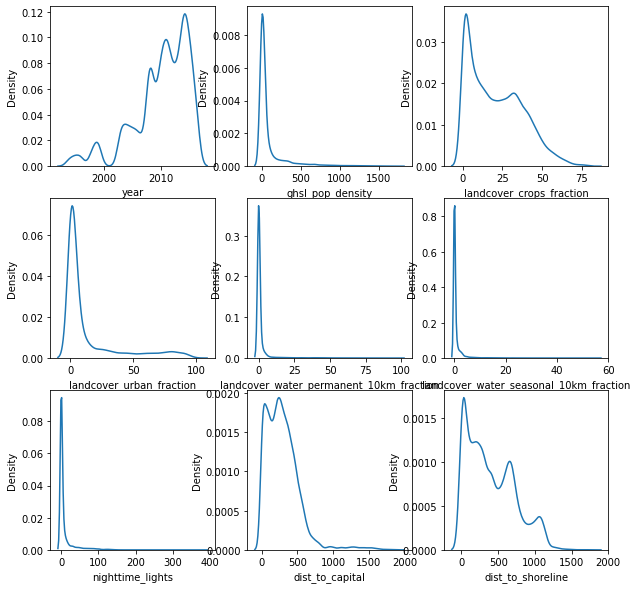

In [10]:
plt.figure(figsize=(10,10))
c = 1
scale = X[["year","ghsl_pop_density","landcover_crops_fraction","landcover_urban_fraction","landcover_water_permanent_10km_fraction","landcover_water_seasonal_10km_fraction","nighttime_lights","dist_to_capital","dist_to_shoreline"]]
for i in scale.columns:
    plt.subplot(3,3,c)
    sns.kdeplot(X[i])
    c = c + 1
plt.show()

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
test[["year","ghsl_pop_density","landcover_crops_fraction","landcover_urban_fraction","landcover_water_permanent_10km_fraction","landcover_water_seasonal_10km_fraction","nighttime_lights","dist_to_capital","dist_to_shoreline"]] = scaler.fit_transform(test[["year","ghsl_pop_density","landcover_crops_fraction","landcover_urban_fraction","landcover_water_permanent_10km_fraction","landcover_water_seasonal_10km_fraction","nighttime_lights","dist_to_capital","dist_to_shoreline"]])
X[["year","ghsl_pop_density","landcover_crops_fraction","landcover_urban_fraction","landcover_water_permanent_10km_fraction","landcover_water_seasonal_10km_fraction","nighttime_lights","dist_to_capital","dist_to_shoreline"]] = scaler.fit_transform(X[["year","ghsl_pop_density","landcover_crops_fraction","landcover_urban_fraction","landcover_water_permanent_10km_fraction","landcover_water_seasonal_10km_fraction","nighttime_lights","dist_to_capital","dist_to_shoreline"]])

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X["country"] = le.fit_transform(X["country"])
X["urban_or_rural"] = le.fit_transform(X["urban_or_rural"])

In [13]:
test["country"] = le.fit_transform(test["country"])
test["urban_or_rural"] = le.fit_transform(test["urban_or_rural"])

<AxesSubplot:>

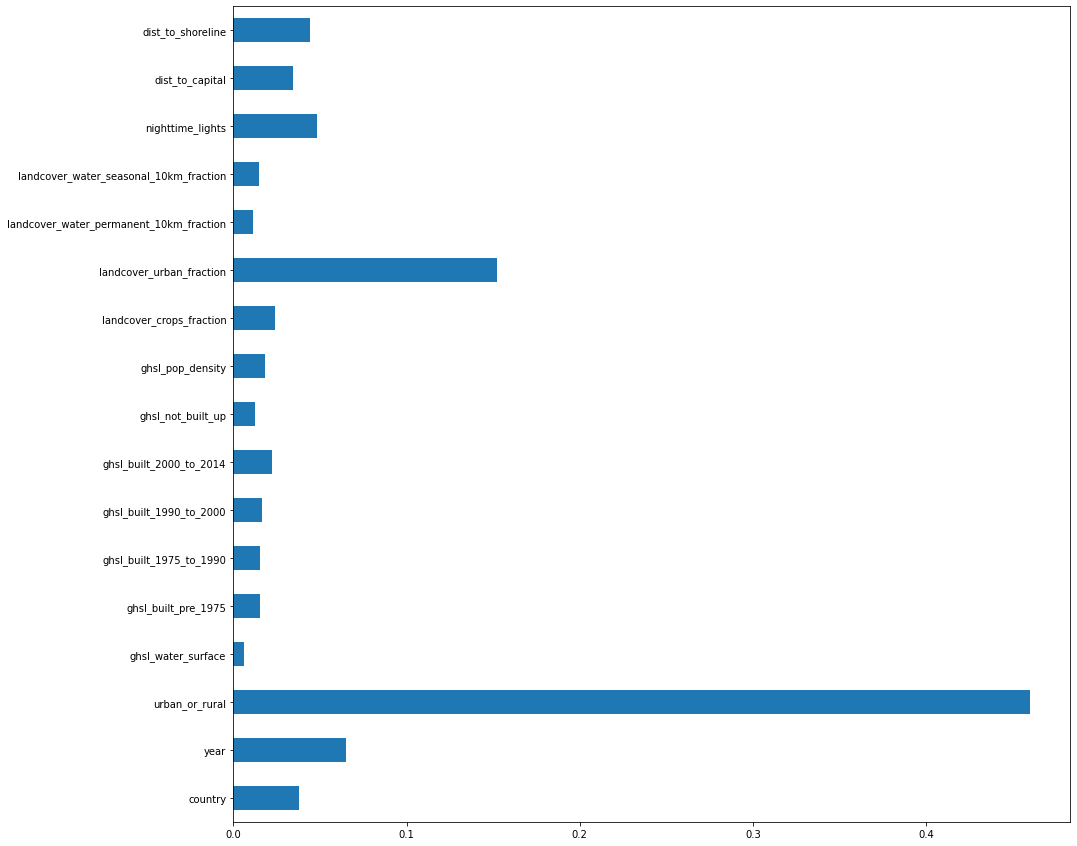

In [13]:
from sklearn.tree import ExtraTreeRegressor
plt.figure(figsize=(15,15))
etr = ExtraTreeRegressor()
etr.fit(X,y)
ft = etr.feature_importances_
ft = pd.Series(ft,index=X.columns)
ft.plot(kind="barh")

In [ ]:
Mo

In [14]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
lr = LinearRegression()
dtr = DecisionTreeRegressor()
rfr = RandomForestRegressor()
svm = SVR()
knn = KNeighborsRegressor()
xgb = XGBRegressor()
lgb = LGBMRegressor()
cbr = CatBoostRegressor(silent=True)
md = {
    "Name": ["linerRegression","DecisionTree","RandomForest","SVM","KNN","XGB","LGBM","CatBoost"],
    "Model":[lr,dtr,rfr,svm,knn,xgb,lgb,cbr]
}

In [91]:
cont = []
from tqdm import tqdm
def val():
    kf = KFold(6)
    for i,j in tqdm(np.array(pd.DataFrame(md))):
        cvs = cross_val_score(j,X,y,cv=kf)
        cont.append([i,np.mean(cvs)])
    score = pd.DataFrame(cont)
    score = score.rename({0:"Model",1:"Score"},axis=1)
    return score
val()

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [11:18<00:00, 84.83s/it]


,Model,Score
0,linerRegression,0.627136
1,DecisionTree,0.603817
2,RandomForest,0.793506
3,SVM,0.714160
4,KNN,0.754227
5,XGB,0.792265
6,LGBM,0.801750
7,CatBoost,0.806454


In [14]:
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score,mean_squared_error as mse
X_train,X_test,y_train,y_test = tts(X,y,test_size=0.2,random_state=2020)

In [21]:
def modelling():
    model = []
    for i,j in tqdm(np.array(pd.DataFrame(md))):
        j.fit(X_train,y_train)
        pred = j.predict(X_test)
        score = r2_score(y_test,pred)
        rmse = np.sqrt(mse(y_test,pred))
        model.append([i,score,rmse])
    score = pd.DataFrame(model)
    score = score.rename({0:"Model",1:"Score",2:"RMSE"},axis=1)
    return score.sort_values(by="RMSE",ascending=True)
modelling()

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:43<00:00, 12.92s/it]


,Model,Score,RMSE
7,CatBoost,0.810719,0.085379
6,LGBM,0.804436,0.086784
2,RandomForest,0.794224,0.089021
5,XGB,0.794186,0.089029
4,KNN,0.764361,0.095262
3,SVM,0.660529,0.114340
0,linerRegression,0.631530,0.119123
1,DecisionTree,0.598228,0.124390


In [19]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
model = LGBMRegressor()
prm = {
    'depth' : [6,8,10],
    'learning_rate' : [0.01,0.05,0.1],
    'n_estimators':[30,50,100],
}
gsv = GridSearchCV(estimator=model,param_grid=prm,verbose=4)
gsv.fit(X_train,y_train)
gsv.best_params_

In [435]:
model = LGBMRegressor(boosting_type="dart",
                     max_depth=0,
                     n_estimators=1000
                     )
model.fit(X_train,y_train)
pred = model.predict(X_test)
print("Score: ",r2_score(y_test,pred))
print("RMSE: ",np.mean(mse(y_test,pred)))

Score:  0.809931204805776
RMSE:  0.007319870085621507


In [409]:
cb = CatBoostRegressor(depth=10,
                      learning_rate=0.05,
                      n_estimators=400,
                       silent=True
                      )
cb.fit(X_train,y_train)
pred = cb.predict(X_test)
print("Score: ",r2_score(y_test,pred))
print("RMSE: ",np.mean(mse(y_test,pred)))

Score:  0.8012859422898675
RMSE:  0.007454685699496107


In [410]:
predict = cb.predict(test)
tst = {"ID":ID,"Target":predict}
tst = pd.DataFrame(tst)
tst.to_csv("first.csv",index=False)